# Classification of Apoptotic cells

In this jupyter notebook, we provide an example of how to extract explainable features and run a classification for the imaging flow cytometry dataset provided by:

In vivo identification of apoptotic and extracellular vesicle-bound live cells using image-based deep learning https://doi.org/10.1080%2F20013078.2020.1792683


We assume you have already installed the library. Otherwise you can install it using 

`!pip -q install <Path to the cloned module>`

This notebook provides an example for deep learning methods

here we import a series of needed modules. 

In [1]:
import scifAI
import numpy as np
from sklearn.datasets import make_classification
import torch.nn as nn
from skorch import NeuralNetClassifier
import matplotlib.pyplot as plt
import glob
from imageio import imread
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
from tqdm import tqdm
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import torch
from torchvision import transforms
from IPython.core.debugger import Tracer
from torch.utils.data import DataLoader, Dataset
from sklearn.pipeline import Pipeline, FeatureUnion
# Compare Algorithms
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import f1_score

In [2]:
from scifAI.dl.utils import calculate_weights, train_validation_test_split, get_statistics
from scifAI.dl.dataset import DatasetGenerator
from scifAI.dl.custom_transforms import ShuffleChannel
from scifAI.dl.models import PretrainedModel, resnet18

In [3]:
from iflai.dl.models import PretrainedModel
from skorch.callbacks import LRScheduler,Checkpoint,EpochScoring,EarlyStopping
import torch.optim as optim
from skorch.helper import predefined_split

here, we provide a function for visualizing the result of the confusion matrix which will be used later.

In [4]:
from sklearn.metrics import (plot_confusion_matrix, 
                             matthews_corrcoef, 
                             classification_report,
                             confusion_matrix, 
                             accuracy_score, 
                             balanced_accuracy_score, 
                             cohen_kappa_score, 
                             f1_score,  
                             precision_score, recall_score)
from imblearn.metrics import classification_report_imbalanced

def classification_complete_report(y_true, y_pred, plot = True ): 
    print(classification_report(y_true, y_pred))
    print(15*"----")
    print("matthews correlation coeff: %.2f" % (matthews_corrcoef(y_true, y_pred)) )
    print("Cohen Kappa score: %.2f" % (cohen_kappa_score(y_true, y_pred)) )
    print("Accuracy: %.2f & balanced Accuracy: %.2f" % (accuracy_score(y_true, y_pred), balanced_accuracy_score(y_true, y_pred)) )
    print("macro F1 score: %.2f & micro F1 score: %.2f" % (f1_score(y_true, y_pred, average = "macro"), f1_score(y_true, y_pred, average = "micro")) )
    print("macro Precision score: %.2f & micro Precision score: %.2f" % (precision_score(y_true, y_pred, average = "macro"), precision_score(y_true, y_pred, average = "micro")) )
    print("macro Recall score: %.2f & micro Recall score: %.2f" % (recall_score(y_true, y_pred, average = "macro"), recall_score(y_true, y_pred, average = "micro")) )
    print(15*"----")
    
    

now lets calculate the metadata:

In [5]:
%%time

data_path = "/pstore/data/DS4/Apoptotic_cell_detection/"
metadata = scifAI.metadata_generator(data_path)

Metadata prepration starts...
Experiment_1 Donor_1 condition_1


100%|██████████| 15311/15311 [00:03<00:00, 4963.49it/s]


...metadata prepration ended.
CPU times: user 257 ms, sys: 179 ms, total: 436 ms
Wall time: 3.75 s


In [6]:
metadata

,file,experiment,donor,condition,object_number,set,label
0,/pstore/data/DS4/Apoptotic_cell_detection/Expe...,Experiment_1,Donor_1,condition_1,822,labeled,apoptotic
1,/pstore/data/DS4/Apoptotic_cell_detection/Expe...,Experiment_1,Donor_1,condition_1,12187,labeled,non-apoptotic
2,/pstore/data/DS4/Apoptotic_cell_detection/Expe...,Experiment_1,Donor_1,condition_1,2295,labeled,apoptotic
3,/pstore/data/DS4/Apoptotic_cell_detection/Expe...,Experiment_1,Donor_1,condition_1,14306,labeled,non-apoptotic
4,/pstore/data/DS4/Apoptotic_cell_detection/Expe...,Experiment_1,Donor_1,condition_1,2584,labeled,apoptotic
...,...,...,...,...,...,...,...
15306,/pstore/data/DS4/Apoptotic_cell_detection/Expe...,Experiment_1,Donor_1,condition_1,10365,labeled,apoptotic
15307,/pstore/data/DS4/Apoptotic_cell_detection/Expe...,Experiment_1,Donor_1,condition_1,2952,labeled,apoptotic
15308,/pstore/data/DS4/Apoptotic_cell_detection/Expe...,Experiment_1,Donor_1,condition_1,7308,labeled,non-apoptotic
15309,/pstore/data/DS4/Apoptotic_cell_detection/Expe...,Experiment_1,Donor_1,condition_1,3211,labeled,apoptotic


['apoptotic' 'non-apoptotic']


<AxesSubplot:>

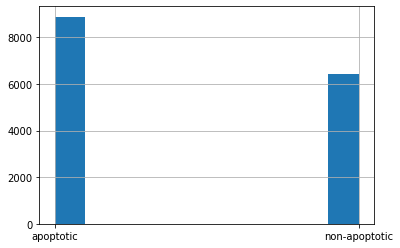

In [7]:
print(metadata.label.unique())
metadata.label.hist()

so we have 31280  files with various labels. first we need to get rid of `unknown` labels

In [8]:
row_index = metadata.label != "unknown"

metadata = metadata.loc[row_index,:].reset_index(drop = True)

lets plot a random image per class

apoptotic
non-apoptotic


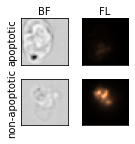

In [9]:
from skimage.util import crop
import h5py

def crop_pad_h_w(image_dummy,reshape_size):
    if image_dummy.shape[0] < reshape_size:
        h1_pad = ( reshape_size - image_dummy.shape[0])/2
        h1_pad = int(h1_pad)
        h2_pad =  reshape_size - h1_pad - image_dummy.shape[0]
        h1_crop = 0
        h2_crop = 0
    else:
        h1_pad = 0
        h2_pad = 0
        h1_crop = ( reshape_size - image_dummy.shape[0])/2
        h1_crop = abs(int(h1_crop))
        h2_crop = image_dummy.shape[0]- reshape_size  - h1_crop

    if image_dummy.shape[1] < reshape_size:
        w1_pad = (reshape_size - image_dummy.shape[1])/2
        w1_pad = int(w1_pad)
        w2_pad = reshape_size - w1_pad - image_dummy.shape[1]
        w1_crop = 0
        w2_crop = 0
    else:
        w1_pad = 0
        w2_pad = 0
        w1_crop = (reshape_size - image_dummy.shape[1])/2
        w1_crop = abs(int(w1_crop))
        w2_crop = image_dummy.shape[1]- reshape_size  - w1_crop

    h = [h1_crop, h2_crop, h1_pad, h2_pad]
    w = [w1_crop, w2_crop, w1_pad, w2_pad] 
    return h, w

def plot_images_with_metadata(metadata,  
                              figsize = None,
                              channels = ["BF","BF", "BF"],
                    channel_colors =  ["Greys", "Oranges", "Blues"],
                    image_size = 128):
    
    metadata_dummy = metadata.copy()
    metadata_dummy = metadata_dummy.reset_index(drop = True)
    
    nrows = len(metadata_dummy)
    ncols = len(channel_colors)
    
    if figsize is None:
        figsize = ( ncols*2, nrows*2 )
    fix,ax = plt.subplots(nrows, ncols, figsize = figsize, tight_layout = True)
    
    vmin = [4095.]*ncols
    vmax = [0.]*ncols
    
    for i in range(nrows):
        h5_file_ = h5py.File(metadata_dummy.loc[i,"file"], "r")
        image = h5_file_.get("image")[()]
        for j, ch in enumerate(range(ncols)):
            vmin[j] = min(vmin[j], image[:,:,ch].min()  )
            vmax[j] = max(vmax[j], image[:,:,ch].max()  )
        
    for i in range(nrows):
        h5_file_ = h5py.File(metadata_dummy.loc[i,"file"], "r")
        image = h5_file_.get("image")[()]         
        
        h, w = crop_pad_h_w(image, image_size)
        h1_crop, h2_crop, h1_pad, h2_pad =  h 
        w1_crop, w2_crop, w1_pad, w2_pad = w 
        for j, ch in enumerate(channel_colors):
            image_dummy = crop(image[:,:,j], ((h1_crop,h2_crop),(w1_crop,w2_crop)))            
            image_dummy = np.pad(image_dummy, 
                                     ((h1_pad,h2_pad),(w1_pad,w2_pad)), 
                                     'constant', 
                                     constant_values = np.mean(image_dummy) )
            ax[i,j].imshow(image_dummy, cmap = channel_colors[j] , vmin = vmin[j], vmax = vmax[j]  )
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            
            if j == 0:
                print(metadata_dummy.loc[i,"label"])
                ax[i,j].set_ylabel(metadata_dummy.loc[i,"label"])
            if i == 0:
                ax[i,j].set_xlabel(channels[j])
                ax[i,j].xaxis.set_label_position('top') 
            
        h5_file_.close()
    plt.tight_layout()

    
plot_images_with_metadata(metadata.groupby('label').apply(lambda s: s.sample(1, random_state = 2)).reset_index(drop = True) ,  
                              figsize = (2,2),
                    channel_colors =  ["Greys", "copper"],
                          channels = ["BF","FL"],
                    image_size = 32)



plt.savefig("Dataset 1 - apoptotic vs non apoptotic cells.png", bbox_inches='tight')
plt.savefig("Dataset 1 - apoptotic vs non apoptotic cells.svg", bbox_inches='tight')

Set all random seeds to the specific value, so the results are more reproducable

In [10]:
seed_value = 42

os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)

np.random.seed(seed_value)
torch.manual_seed(seed_value)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Define all necessary parameters

In [11]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [12]:
class MinMaxScaler(object):
    def __init__(self, min_in , max_in, min_out, max_out):
        self.min_in = min_in.reshape(-1,1,1)
        self.max_in = max_in.reshape(-1,1,1)
        self.min_out = min_out
        self.max_out = max_out
        
    def __call__(self, tensor):
        
        tensor_ = (tensor - self.min_in)/(self.max_in - self.min_in)
        tensor_ = tensor_*(self.max_out - self.min_out) + self.min_out
        tensor_[tensor_<self.min_out]= self.min_out
        tensor_[tensor_>self.max_out]= self.max_out
        return tensor_
    
    def __repr__(self):
        return self.__class__.__name__ + '(min_out={0}, max_out={1})'.format(self.min_out, self.max_out)

In [13]:

model_dir = "models"
log_dir = "logs"
scaling_factor = 255.
reshape_size = 32
num_classes = len(metadata.label.unique())

In [14]:

selected_channels = np.arange(2)
num_channels = len(selected_channels)
channels = np.asarray([ "Ch" + str(i) for i in selected_channels])
num_of_all_channels = len(channels)
all_channels = np.arange(num_of_all_channels)

In [15]:
batch_size = 128
num_workers = 4
device="cuda"

splitting data to train, validaiton and test

In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

skf = StratifiedKFold(n_splits=5, random_state=seed_value, shuffle=True)
main_fold = 4
i = 1
for train_index, test_index in skf.split(metadata.index.tolist(), metadata["label"]):
    if i == main_fold:
        break
    else:
        print(i)
        i+=1


train_index, validation_index, _, _ = train_test_split(train_index, 
                                                    metadata.loc[train_index,"label"].index.tolist(), 
                                                    stratify = metadata.loc[train_index,"label"].tolist(),
                                                    test_size=0.2, 
                                                    random_state=seed_value)

1
2
3


In [17]:
label_map = dict(zip(sorted(set(metadata.loc[train_index, "label"])), 
                     np.arange(len(set(metadata.loc[train_index, "label"])))))

set_of_interesting_classes = metadata.label.unique().tolist()

label_map

{'apoptotic': 0, 'non-apoptotic': 1}

now we calculate the statistics of every channel to later use for nomalizing the dataset

In [18]:
train_dataset = DatasetGenerator(metadata=metadata.loc[train_index,:],
                                 label_map=label_map,
                                 selected_channels=selected_channels,
                                 scaling_factor=scaling_factor,
                                 reshape_size=reshape_size,
                                 transform=transforms.Compose([]))

In [19]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

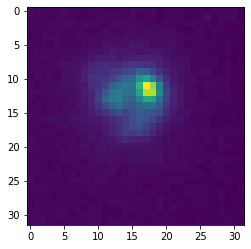

In [20]:
plt.imshow(train_dataset[0][0][1])

In [21]:
statistics = get_statistics(train_loader, selected_channels=selected_channels)

100%|██████████| 77/77 [00:25<00:00,  3.03it/s]

statistics used: {'min': tensor([1.4757, 0.0000]), 'p01': tensor([2.5295, 0.0172]), 'p05': tensor([2.8071, 0.0272]), 'p25': tensor([3.0940, 0.0482]), 'p50': tensor([3.1461, 0.0761]), 'p75': tensor([3.1876, 0.1634]), 'p95': tensor([3.4514, 0.7914]), 'p99': tensor([3.7498, 2.1942]), 'max': tensor([  5.2048, 250.7378]), 'mean': tensor([3.1395, 0.2242]), 'std': tensor([0.1973, 1.9192])}


adding the normalization to each transform

In [22]:
stats = dict()
stats["lower_bound"] = torch.tensor([statistics['min'][0], statistics['p01'][1]])
stats["upper_bound"] = torch.tensor([statistics['p99'][0], statistics['p99'][1]])

train_transform = [ 
        MinMaxScaler(           min_in =  stats["lower_bound"] , 
                                max_in =  stats["upper_bound"] , 
                                min_out =  0. , 
                                max_out =  1.),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        AddGaussianNoise(mean=0., std=0.01),
]

validation_transform =  [ 
        MinMaxScaler(           min_in =  stats["lower_bound"] , 
                                max_in =  stats["upper_bound"] , 
                                min_out =  0. , 
                                max_out =  1.),
]

test_transform =  [ 
        MinMaxScaler(           min_in =  stats["lower_bound"] , 
                                max_in =  stats["upper_bound"] , 
                                min_out =  0. , 
                                max_out =  1.),
]

In [23]:
train_loader = None

defining train, validation and test datasets

In [24]:
train_dataset = DatasetGenerator(metadata=metadata.loc[train_index,:],
                                 label_map=label_map,
                                 selected_channels=selected_channels,
                                 scaling_factor=scaling_factor, 
                                 reshape_size=reshape_size,
                                 transform= transforms.Compose(train_transform))

validation_dataset = DatasetGenerator(metadata=metadata.loc[validation_index,:],
                                      label_map=label_map,
                                      selected_channels=selected_channels,
                                      scaling_factor=scaling_factor,
                                      reshape_size=reshape_size,
                                      transform=transforms.Compose(test_transform))

test_dataset = DatasetGenerator(metadata=metadata.loc[test_index,:],
                                label_map=label_map,
                                selected_channels=selected_channels,
                                scaling_factor=scaling_factor,
                                reshape_size=reshape_size,
                                transform=
                                transforms.Compose(test_transform))

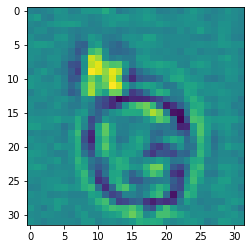

In [25]:
plt.imshow(test_dataset[0][0][0])

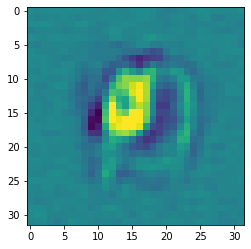

In [26]:
plt.imshow(validation_dataset[0][0][0])

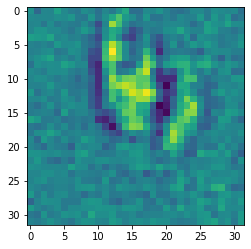

In [27]:
plt.imshow(train_dataset[0][0][0])

considering that we have multiple input channels, we need to modify the ResNet18 network input layer

In [28]:
import torch.nn as nn
from scifAI.dl.models import PretrainedModel
import torch.nn.functional as F

resnet18_modified = PretrainedModel(len(selected_channels),
                                     len(set_of_interesting_classes), 
                                     pretrained = True)

finally, we add a scheduler and an early stopping based on valid_f1_macro

In [29]:
lr_scheduler = LRScheduler(policy='ReduceLROnPlateau', factor=0.5, patience=5)

epoch_scoring_f1_micro = EpochScoring("f1_micro", 
                             name =  "valid_f1_micro", 
                             on_train = False,
                             lower_is_better = False)

epoch_scoring_f1_macro = EpochScoring("f1_macro", 
                             name =  "valid_f1_macro", 
                             on_train = False,
                             lower_is_better = False)

early_stopping = EarlyStopping(monitor='valid_f1_macro', 
                               patience=50, 
                               threshold=0.0001, 
                               threshold_mode='rel', 
                               lower_is_better=False)

checkpoint = Checkpoint(f_params='apoptotic_cells_DL_fold4.pth',
                        monitor='valid_f1_macro_best', load_best=True)

lets define and train the model using `skorch`

In [30]:
net = NeuralNetClassifier(    
    resnet18_modified, 
    criterion=nn.CrossEntropyLoss,
    lr=0.001,
    batch_size=batch_size,
    max_epochs=1000,
    optimizer=optim.Adam,
    iterator_train__shuffle=True,
    iterator_train__num_workers=num_workers,
    iterator_valid__shuffle=False,
    iterator_valid__num_workers=2,
    callbacks=[lr_scheduler, epoch_scoring_f1_micro, 
               epoch_scoring_f1_macro, 
               early_stopping, checkpoint],
    train_split=predefined_split(validation_dataset),
    device="cuda",
    warm_start=True)

In [31]:
net = net.fit(train_dataset, y = None)

  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        0.4092       0.6090            0.5887            0.6090        1.0056     +  6.4685
      2        0.2637       0.8816            0.8792            0.8816        0.3041     +  6.2093
      3        0.2258       0.9029            0.9009            0.9029        0.2341     +  6.3370
      4        0.2104       0.8996            0.8942            0.8996        0.2696        6.9688
      5        0.1953       0.9069            0.9058            0.9069        0.2352     +  6.4445
      6        0.1818       0.9090            0.9075            0.9090        0.2272     +  6.7154
      7        0.1758       0.9229            0.9203            0.9229        0.2061     +  6.3536
      8        0.1708       0.9127            0.9083            0.9127        0.2154        6.5445
      9   

     74        0.0280       0.9392            0.9375            0.9392        0.2085        6.4114
     75        0.0185       0.9384            0.9363            0.9384        0.2532        6.4237
     76        0.0171       0.9376            0.9359            0.9376        0.2545        6.5678
     77        0.0182       0.9400            0.9383            0.9400        0.2460        6.3426
     78        0.0192       0.9424            0.9409            0.9424        0.2447        6.3851
     79        0.0168       0.9404            0.9386            0.9404        0.2596        6.3802
     80        0.0182       0.9392            0.9374            0.9392        0.2400        6.4848
     81        0.0173       0.9392            0.9377            0.9392        0.2817        6.5560
     82        0.0172       0.9359            0.9342            0.9359        0.3260        6.4492
     83        0.0158       0.9396            0.9379            0.9396        0.2912        6.4240
     84   

In [32]:
net.module.load_state_dict(torch.load('apoptotic_cells_DL_fold4.pth')) 

<All keys matched successfully>



lets take a look the prediction pefromance for the validation set

In [33]:
inv_label_map = {v: k for k, v in label_map.items()}

preds = net.predict(validation_dataset)
preds =  [inv_label_map[int(t)] for t in preds]

classification_complete_report(validation_dataset.metadata.label, 
                               preds  )

               precision    recall  f1-score   support

    apoptotic       0.94      0.96      0.95      1422
non-apoptotic       0.95      0.92      0.93      1028

     accuracy                           0.95      2450
    macro avg       0.95      0.94      0.94      2450
 weighted avg       0.95      0.95      0.95      2450

------------------------------------------------------------
matthews correlation coeff: 0.89
Cohen Kappa score: 0.89
Accuracy: 0.95 & balanced Accuracy: 0.94
macro F1 score: 0.94 & micro F1 score: 0.95
macro Precision score: 0.95 & micro Precision score: 0.95
macro Recall score: 0.94 & micro Recall score: 0.95
------------------------------------------------------------


and finally for the test set

In [34]:
preds = net.predict(test_dataset)
preds =  [inv_label_map[int(t)] for t in preds]

classification_complete_report(test_dataset.metadata.label, 
                               preds  )

               precision    recall  f1-score   support

    apoptotic       0.94      0.95      0.95      1777
non-apoptotic       0.93      0.92      0.93      1285

     accuracy                           0.94      3062
    macro avg       0.94      0.94      0.94      3062
 weighted avg       0.94      0.94      0.94      3062

------------------------------------------------------------
matthews correlation coeff: 0.87
Cohen Kappa score: 0.87
Accuracy: 0.94 & balanced Accuracy: 0.94
macro F1 score: 0.94 & micro F1 score: 0.94
macro Precision score: 0.94 & micro Precision score: 0.94
macro Recall score: 0.94 & micro Recall score: 0.94
------------------------------------------------------------


In [35]:
performance_with_all_channels = pd.read_csv("performance_with_all_channels.csv")

performance_with_all_channels.loc[main_fold,"accuracy"] = accuracy_score(test_dataset.metadata.label, preds)
performance_with_all_channels.loc[main_fold,"f1_macro"] = f1_score(test_dataset.metadata.label, preds, average="macro")
performance_with_all_channels.loc[main_fold,"f1_micro"] = f1_score(test_dataset.metadata.label, preds, average="micro")

performance_with_all_channels.to_csv("performance_with_all_channels.csv", index = False)

In [36]:
model = net.module_
net = None
torch.cuda.empty_cache()

### Model Interpretation

In [37]:
# where to save results
model_name = "resnet18"
dataset_name = "apoptotic vs. non-apoptotic"

#### Pixel-Permutation Tests

In [38]:
from time import process_time

In [39]:

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [40]:
correct = 0.
total = 0.
y_true = list()
y_pred = list()
y_true_proba = list()
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data[0].to(device).float(), data[1].to(device).long()
        outputs = model(inputs)
        pred = outputs.argmax(dim=1)
        true_proba = np.array([j[i] for (i,j) in zip(pred, outputs.cpu())])
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (labels.reshape(-1) == predicted).sum().item()
        for i in range(len(pred)):
            y_true.append(labels[i].item())
            y_pred.append(pred[i].item())
            y_true_proba.append(true_proba[i].item())

In [41]:
class_names_targets = [c for c in label_map.keys()]

In [42]:
print(classification_report(y_true, y_pred, target_names=class_names_targets, digits=2))

               precision    recall  f1-score   support

    apoptotic       0.94      0.95      0.95      1777
non-apoptotic       0.93      0.92      0.93      1285

     accuracy                           0.94      3062
    macro avg       0.94      0.94      0.94      3062
 weighted avg       0.94      0.94      0.94      3062



100%|██████████| 100/100 [02:34<00:00,  1.55s/it]

Candidate channel  to remove is 0


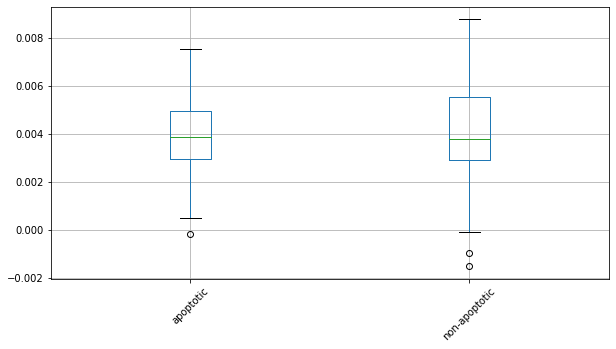

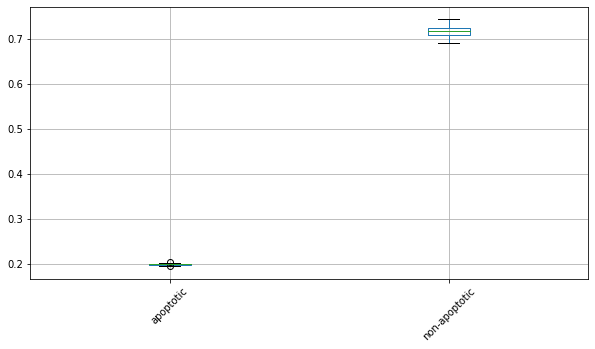

In [43]:
t1_start = process_time()
f1_score_original = f1_score(y_true, y_pred, average=None, labels=np.arange(num_classes))
min_mean_dif = 1.0
candidate = 0
shuffle_times = 100
df_all = pd.DataFrame([], columns=class_names_targets)
for c in range(num_channels):
    f1_score_diff_from_original_per_channel_per_shuffle = []
    transform = test_transform.copy()
    transform.append(ShuffleChannel(channels_to_shuffle=[c]))
    for s in tqdm(range(shuffle_times)):
        dataset = DatasetGenerator(metadata=metadata.loc[test_index,:],
                                 label_map=label_map,
                                 selected_channels=selected_channels,
                                 scaling_factor=scaling_factor,
                                 reshape_size=reshape_size,
                                 transform=transforms.Compose(transform))
        dataloader = DataLoader(dataset,
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=num_workers)
        y_true = list()
        y_pred = list()
        with torch.no_grad():
            for data in dataloader:
                inputs, labels = data[0].to(device).float(), data[1].to(device).reshape(-1).long()
                outputs = model(inputs)
                pred = outputs.argmax(dim=1)
                for i in range(len(pred)):
                    y_true.append(labels[i].item())
                    y_pred.append(pred[i].item())
            f1_score_per_channel = f1_score(y_true, y_pred, average=None, labels=np.arange(num_classes))
            f1_score_diff_from_original_per_channel_per_shuffle.append(f1_score_original - f1_score_per_channel)
    mean_along_columns = np.mean(f1_score_diff_from_original_per_channel_per_shuffle, axis=0)
    mean_dif = np.mean(mean_along_columns)
    if mean_dif < min_mean_dif and mean_dif > 0 and not selected_channels[c]:
        min_mean_dif = mean_dif
        candidate = selected_channels[c]
    df_diff = pd.DataFrame(np.atleast_2d(f1_score_diff_from_original_per_channel_per_shuffle), columns=class_names_targets)
    df_mean_diff = pd.DataFrame(np.atleast_2d(mean_along_columns), columns=class_names_targets)
    df_all = pd.concat([df_all, df_mean_diff], ignore_index=True, sort=False)
    fig, ax = plt.subplots(figsize=(10, 5))
    ax = df_diff.boxplot()
    ax.set_xticklabels(class_names_targets, rotation=45)
    #fig.savefig(os.path.join("results",model_name, "{}-shuffle_method-model-{}-channel-{}.png".format(dataset_name, str(model_name), str(selected_channels[c]))))
print("Candidate channel  to remove is {}".format(candidate))

<BarContainer object of 2 artists>

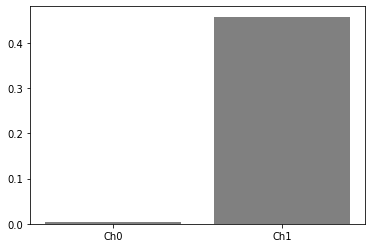

In [44]:
plt.bar(channels[selected_channels], df_all.T.mean(), color='Grey')
#plt.savefig(os.path.join("results",model_name, "{}-pixel-permutation-method-model-all-{}.svg".format(dataset_name, str("resnet_all"))))

In [45]:
channel_ranking_pixel_permutation = pd.DataFrame(data={'channels': channels[np.asarray(selected_channels)], 'importance': df_all.T.mean().to_numpy()})

In [46]:
from captum.attr import (
    GuidedGradCam,
    DeepLift,
    Saliency,
    DeepLiftShap,
    GradientShap,
    InputXGradient,
    IntegratedGradients,
    GuidedBackprop,
    Deconvolution,
    Occlusion,
    FeaturePermutation,
    ShapleyValueSampling,
    Lime,
    KernelShap,
    LRP
)
from time import process_time

In [47]:
def run_interpretation_method(ablator, method_name, require_baseline=False, require_sliding_window=False):
    t1_start = process_time()
    dataset = DatasetGenerator(metadata=metadata.loc[test_index,:],
                                     label_map=label_map,
                                     selected_channels=selected_channels,
                                     scaling_factor=scaling_factor,
                                     reshape_size=reshape_size,
                                     transform=transforms.Compose(test_transform))
    testloader = DataLoader(test_dataset,
                                    batch_size=batch_size,
                                    shuffle=False,
                                    num_workers=num_workers)

    heatmaps = torch.empty(0, dtype=torch.float32, device=device)
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data[0].to(device).float(), data[1].to(device).reshape(-1).long()
            if require_baseline:
                baselines=torch.zeros(inputs.shape).to(device)
                attr = ablator.attribute(inputs, target=labels, baselines=baselines)
            elif require_sliding_window:
                attr = ablator.attribute(inputs, target=labels, sliding_window_shapes=(1,3,3))
            else:
                attr = ablator.attribute(inputs, target=labels)
            heatmaps = torch.cat((heatmaps,  torch.from_numpy(np.percentile(torch.flatten(attr, start_dim=-2).cpu().numpy(), q=50, axis=-1)).to(device)))
    heatmaps_mean = torch.mean(heatmaps, dim=0)
    plt.bar(channels, heatmaps_mean.cpu(), color='grey')
    #plt.savefig(os.path.join("results", "resnet_all", "{}-{}_method-model-50-percentile-{}.png".format(dataset_name, method_name, str("resnet_all"))))

    t1_stop = process_time()
    print("Elapsed time:", t1_stop, t1_start) 

    print("Elapsed time during the whole program in seconds:",
                                             t1_stop-t1_start)
    return heatmaps_mean

In [48]:
# DeepLift

Elapsed time: 561.011135226 559.344334009
Elapsed time during the whole program in seconds: 1.6668012169999429


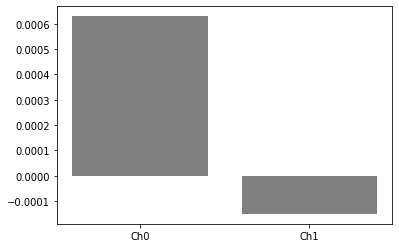

In [49]:
dl = DeepLift(model)
heatmaps_deeplift_mean = run_interpretation_method(dl, 'dl')

In [50]:
# Saliency

Elapsed time: 562.268220787 561.129296711
Elapsed time during the whole program in seconds: 1.1389240759999666


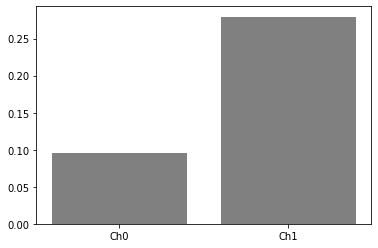

In [51]:
saliency = Saliency(model)
heatmaps_saliency_mean = run_interpretation_method(saliency, 'saliency')

In [52]:
# IntegratedGradients

Elapsed time: 583.236661815 562.374657033
Elapsed time during the whole program in seconds: 20.8620047820001


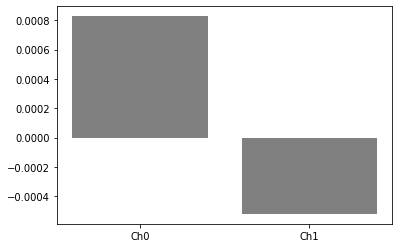

In [53]:
ig = IntegratedGradients(model)
heatmaps_integrated_gradient_mean = run_interpretation_method(ig, 'IntegratedGradients')

In [54]:
# LRP

Elapsed time: 584.709210801 583.335043464
Elapsed time during the whole program in seconds: 1.3741673370000171


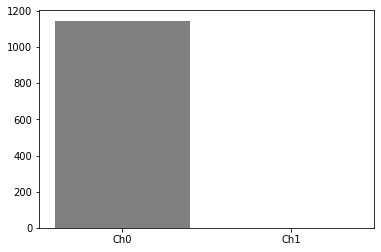

In [55]:
lrp = LRP(model)
heatmaps_lrp_mean = run_interpretation_method(lrp, 'LRP')

In [56]:
# GuidedGradCAM

Elapsed time: 586.514900086 584.806756539
Elapsed time during the whole program in seconds: 1.7081435469999633


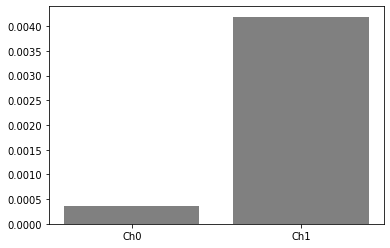

In [57]:
guided_cram = GuidedGradCam(model, model.model.layer1)
heatmaps_gradcam_mean = run_interpretation_method(guided_cram, 'GuidedGradCam')

In [58]:
channel_ranking_pixel_permutation

,channels,importance
0,Ch0,0.003956
1,Ch1,0.458152


5fold CV on the data and get the importance per fold for statistical evaluation
    
our result is in alignment with the original paper. On the other hand, guided gradcam failed

In [59]:
channel_importance = pd.read_csv("channel_importance.csv")

channel_importance_fold = pd.DataFrame(columns = channel_importance.columns)

channel_importance_fold["channel"] = channels
channel_importance_fold["fold"] = main_fold
channel_importance_fold["PXPermute"] = channel_ranking_pixel_permutation["importance"]
channel_importance_fold["DeepLift"] = heatmaps_deeplift_mean.cpu().numpy()
channel_importance_fold["IntegratedGradients"] = heatmaps_integrated_gradient_mean.cpu().numpy()
channel_importance_fold["LRP"] = heatmaps_lrp_mean.cpu().numpy()
channel_importance_fold["GuidedGradCAM"] = heatmaps_gradcam_mean.cpu().numpy()

channel_importance = channel_importance.append(channel_importance_fold, ignore_index = True)

channel_importance.to_csv("channel_importance.csv", index = False)